In [14]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
import tensorflow as tf
from tensorflow.python.framework import ops
from dnn_utils import *
from cnn_utils import *

%matplotlib inline
np.random.seed(1)

In [15]:
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_data()

In [17]:
X_train_orig.shape

(209, 64, 64, 3)

y = 1


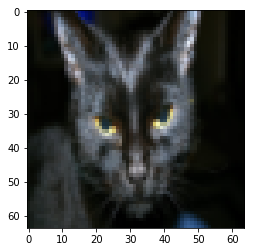

In [18]:
# Example of a picture
index = 25
plt.imshow(X_train_orig[index])
print ("y = " + str(np.squeeze(Y_train_orig[:, index])))

In [111]:
Y_train_orig.shape
len(Y_train_orig)

1

In [115]:
X_train = X_train_orig/255.
X_test = X_test_orig/255.
#Y_train = convert_to_one_hot(Y_train_orig, 256).T
#Y_test = convert_to_one_hot(Y_test_orig, 256).T
Y_train = Y_train_orig.T
Y_test = Y_test_orig.T
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))
conv_layers = {}

number of training examples = 209
number of test examples = 50
X_train shape: (209, 64, 64, 3)
Y_train shape: (209, 1)
X_test shape: (50, 64, 64, 3)
Y_test shape: (50, 1)


In [90]:
def create_placeholders(n_H0, n_W0, n_C0, n_y):
    """
    Creates the placeholders for the tensorflow session.
    
    Arguments:
    n_H0 -- scalar, height of an input image
    n_W0 -- scalar, width of an input image
    n_C0 -- scalar, number of channels of the input
    n_y -- scalar, number of classes
        
    Returns:
    X -- placeholder for the data input, of shape [None, n_H0, n_W0, n_C0] and dtype "float"
    Y -- placeholder for the input labels, of shape [None, n_y] and dtype "float"
    """

    ### START CODE HERE ### (≈2 lines)
    X = tf.placeholder(tf.float32, shape=(None, n_H0, n_W0, n_C0))
    Y = tf.placeholder(tf.float32, shape=(None, n_y))
    ### END CODE HERE ###
    
    return X, Y

In [91]:
# TEST create_placeholders
X, Y = create_placeholders(64, 64, 3, 1)
print ("X = " + str(X))
print ("Y = " + str(Y))

X = Tensor("Placeholder_2:0", shape=(?, 64, 64, 3), dtype=float32)
Y = Tensor("Placeholder_3:0", shape=(?, 1), dtype=float32)


In [92]:
def initialize_parameters():
    """
    Initializes weight parameters to build a neural network with tensorflow. The shapes are:
                        W1 : [16, 16, 3, 64]
                        W2 : [4, 4, 64, 112]
                        W3 : [3, 3, 112, 80]
    Returns:
    parameters -- a dictionary of tensors containing W1, W2
    """
    
    tf.set_random_seed(1)                              # so that your "random" numbers match ours
        
    ### START CODE HERE ### (approx. 2 lines of code)
    W1 = tf.get_variable("W1", [16, 16, 3, 64], initializer = tf.contrib.layers.xavier_initializer(seed = 0))
    W2 = tf.get_variable("W2", [4, 4, 64, 112], initializer = tf.contrib.layers.xavier_initializer(seed = 0))
    W3 = tf.get_variable("W3", [3, 3, 112, 80], initializer = tf.contrib.layers.xavier_initializer(seed = 0))
    ### END CODE HERE ###

    parameters = {"W1": W1,
                  "W2": W2,
                  "W3": W3}
                    
    
    return parameters

In [93]:
# TEST initialize_parameters()

tf.reset_default_graph()
with tf.Session() as sess_test:
    parameters = initialize_parameters()
    init = tf.global_variables_initializer()
    sess_test.run(init)
    print("W1 = " + str(parameters["W1"].eval()[1,1,1]))
    print("W2 = " + str(parameters["W2"].eval()[1,1,1]))
    print("W3 = " + str(parameters["W3"].eval()[1,1,1]))

W1 = [ 0.0027647  -0.0077795  -0.00304792  0.00090467  0.00367539  0.0038213
  0.01253349 -0.0159151  -0.00997316  0.00989146 -0.00479552  0.01361945
  0.01547712 -0.0119383   0.00454234 -0.00672215  0.01670513 -0.00930354
  0.00986782  0.01125874 -0.01468413 -0.01602734 -0.01236281  0.00961787
  0.0171022  -0.0144546   0.00537214  0.01856242 -0.00941688 -0.00793696
 -0.01145867  0.00704338 -0.00686152  0.01196256  0.01126715 -0.00276822
 -0.00755815  0.01751693 -0.01391768  0.01121802  0.00739968 -0.00777832
 -0.00735548  0.01287578 -0.00596841 -0.01481874  0.00127283 -0.00011229
 -0.0098048  -0.00958912  0.00275009 -0.01649374  0.00733565 -0.01611976
  0.00211852  0.00421502 -0.00773812  0.0039575  -0.00411476 -0.0088917
 -0.00749753  0.01293227  0.01121505  0.01247304]
W2 = [ 0.00987728 -0.04277753 -0.04232451 -0.01148411  0.03429854 -0.02573285
  0.03506614  0.04167503 -0.01023433 -0.02575316 -0.00915407 -0.01656264
  0.01935149 -0.01952656  0.00424414  0.00425741  0.0195312  -0.02

In [104]:
def forward_propagation(X, parameters):
    """
    Implements the forward propagation for the model:
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> CONV2D -> RELU -> FLATTEN -> FULLYCONNECTED -> RELU -> FULLYCONNECTED
    
    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters "W1", "W2", "W3"
                  the shapes are given in initialize_parameters

    Returns:
    Z6 -- the output of the last LINEAR unit
    """
    
    # Retrieve the parameters from the dictionary "parameters" 
    W1 = parameters['W1']
    W2 = parameters['W2']
    W3 = parameters['W3']
    ### START CODE HERE ###
    # CONV2D: stride of 4, padding 'SAME'
    Z1 = tf.nn.conv2d(X, W1, strides = [1,4,4,1], padding = 'SAME')
    # RELU
    A1 = tf.nn.relu(Z1)
    # MAXPOOL: window 2x2, sride 1, padding 'SAME'
    P1 = tf.nn.max_pool(A1, ksize = [1,2,2,1], strides = [1,1,1,1], padding = 'SAME')
    # CONV2D: filters W2, stride of 1, padding 'SAME'
    Z2 = tf.nn.conv2d(P1, W2, strides = [1,1,1,1], padding = 'SAME')
    # RELU
    A2 = tf.nn.relu(Z2)
    # CONV2D: filters W3, stride 1, padding 'SAME'
    Z3 = tf.nn.conv2d(A2, W3, strides = [1,1,1,1], padding = 'SAME')
    # RELU
    A3 = tf.nn.relu(Z3)
    # FLATTEN
    A3 = tf.contrib.layers.flatten(A3)
    # FULLY-CONNECTED
    Z4 = tf.contrib.layers.fully_connected(A3, 4096)
    A4 = tf.nn.relu(Z4)
    Z5 = tf.contrib.layers.fully_connected(A4, activation_fn=None)
    #A5 = tf.nn.sigmoid(Z5)
    #Z6 = tf.contrib.layers.fully_connected(A5, 1, activation_fn=None)
    ### END CODE HERE ###

    return Z5

In [105]:
# TEST forward_propagation()

tf.reset_default_graph()

with tf.Session() as sess:
    np.random.seed(1)
    X, Y = create_placeholders(64, 64, 3, 1)
    parameters = initialize_parameters()
    Z6 = forward_propagation(X, parameters)
    init = tf.global_variables_initializer()
    sess.run(init)
    a = sess.run(Z6, {X: np.random.randn(3,64,64,3), Y: np.random.randn(3,1)})
    print("Z6 = " + str(a))

Z6 = [[ 0.23497272]
 [ 0.22212547]
 [ 0.23550946]]


In [106]:
def compute_cost(Z6, Y):
    """
    Computes the cost
    
    Arguments:
    Z6 -- output of forward propagation (output of the last LINEAR unit), of shape (1, number of examples)
    Y -- "true" labels vector placeholder, same shape as Z6
    
    Returns:
    cost - Tensor of the cost function
    """
    
    ### START CODE HERE ### (1 line of code)
    cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = Z6, labels = Y))
    ### END CODE HERE ###
    
    return cost

In [107]:
tf.reset_default_graph()

with tf.Session() as sess:
    np.random.seed(1)
    X, Y = create_placeholders(64, 64, 3, 1)
    parameters = initialize_parameters()
    Z6 = forward_propagation(X, parameters)
    cost = compute_cost(Z6, Y)
    init = tf.global_variables_initializer()
    sess.run(init)
    a = sess.run(cost, {X: np.random.randn(4,64,64,3), Y: np.random.randn(4,1)})
    print("cost = " + str(a))

cost = 0.916546


In [108]:
def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.009,
          num_epochs = 100, minibatch_size = 64, print_cost = True):
    """
    Implements a three-layer ConvNet in Tensorflow:
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> CONV2D -> RELU -> FLATTEN -> FULLYCONNECTED -> RELU -> FULLYCONNECTED
    
    Arguments:
    X_train -- training set, of shape (None, 64, 64, 3)
    Y_train -- test set, of shape (None, n_y = 256)
    X_test -- training set, of shape (None, 64, 64, 3)
    Y_test -- test set, of shape (None, n_y = 256)
    learning_rate -- learning rate of the optimization
    num_epochs -- number of epochs of the optimization loop
    minibatch_size -- size of a minibatch
    print_cost -- True to print the cost every 100 epochs
    
    Returns:
    train_accuracy -- real number, accuracy on the train set (X_train)
    test_accuracy -- real number, testing accuracy on the test set (X_test)
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    tf.set_random_seed(1)                             # to keep results consistent (tensorflow seed)
    seed = 3                                          # to keep results consistent (numpy seed)
    (m, n_H0, n_W0, n_C0) = X_train.shape             
    n_y = Y_train.shape[1]                            
    costs = []                                        # To keep track of the cost
    
    # Create Placeholders of the correct shape
    ### START CODE HERE ### (1 line)
    X, Y = create_placeholders(n_H0, n_W0, n_C0, n_y)
    ### END CODE HERE ###

    # Initialize parameters
    ### START CODE HERE ### (1 line)
    parameters = initialize_parameters()
    ### END CODE HERE ###
    
    # Forward propagation: Build the forward propagation in the tensorflow graph
    ### START CODE HERE ### (1 line)
    Z6 = forward_propagation(X, parameters)
    ### END CODE HERE ###
    
    # Cost function: Add cost function to tensorflow graph
    ### START CODE HERE ### (1 line)
    cost = compute_cost(Z6, Y)
    ### END CODE HERE ###
    
    # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer that minimizes the cost.
    ### START CODE HERE ### (1 line)
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

    ### END CODE HERE ###
    
    # Initialize all the variables globally
    init = tf.global_variables_initializer()
     
    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:
        
        # Run the initialization
        sess.run(init)
        
        # Do the training loop
        for epoch in range(num_epochs):

            minibatch_cost = 0.
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

            for minibatch in minibatches:

                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch
                # IMPORTANT: The line that runs the graph on a minibatch.
                # Run the session to execute the optimizer and the cost, the feedict should contain a minibatch for (X,Y).
                ### START CODE HERE ### (1 line)
                _ , temp_cost = sess.run([optimizer, cost], feed_dict={X:minibatch_X, Y:minibatch_Y})
                ### END CODE HERE ###
                
                minibatch_cost += temp_cost / num_minibatches
                

            # Print the cost every epoch
            if print_cost == True and epoch % 5 == 0:
                print ("Cost after epoch %i: %f" % (epoch, minibatch_cost))
            if print_cost == True and epoch % 1 == 0:
                costs.append(minibatch_cost)
        
        
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # Calculate the correct predictions
        predict_op = tf.argmax(Z6, 1)
        correct_prediction = tf.equal(predict_op, tf.argmax(Y, 1))
        
        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        print(accuracy)
        train_accuracy = accuracy.eval({X: X_train, Y: Y_train})
        test_accuracy = accuracy.eval({X: X_test, Y: Y_test})
        print("Train Accuracy:", train_accuracy)
        print("Test Accuracy:", test_accuracy)
                
        return train_accuracy, test_accuracy, parameters

Cost after epoch 0: 2.067527
Cost after epoch 5: 0.908472
Cost after epoch 10: 0.893745
Cost after epoch 15: 0.871641
Cost after epoch 20: 0.851932
Cost after epoch 25: 0.852206
Cost after epoch 30: 0.849753
Cost after epoch 35: 0.840625
Cost after epoch 40: 0.844368
Cost after epoch 45: 0.910082
Cost after epoch 50: 0.835885
Cost after epoch 55: 0.883115
Cost after epoch 60: 0.845864
Cost after epoch 65: 0.860351
Cost after epoch 70: 0.867607
Cost after epoch 75: 0.852982
Cost after epoch 80: 0.873485
Cost after epoch 85: 0.848014
Cost after epoch 90: 0.872270
Cost after epoch 95: 0.870708


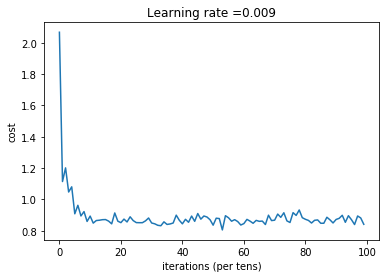

Tensor("Mean_1:0", shape=(), dtype=float32)
Train Accuracy: 1.0
Test Accuracy: 1.0


In [109]:
_, _, parameters = model(X_train, Y_train, X_test, Y_test)

In [117]:
len(plt.imread('/home/kolaleye/lustre/onitemi/data/mbd/training/building_bitmaps/24478885_15.tif'))

1500

In [179]:
data = plt.imread('/home/kolaleye/lustre/onitemi/data/mbd/training/24478885_15.tiff')

In [180]:
import cv2

In [198]:
data_small = cv2.resize(data, (100, 100))

In [199]:
data[1499,1499]

array([61, 56, 52], dtype=uint8)

In [201]:
data_small[99,99]

array([93, 90, 72], dtype=uint8)

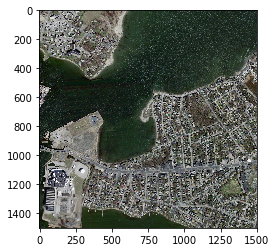

In [182]:
plt.imshow(data)

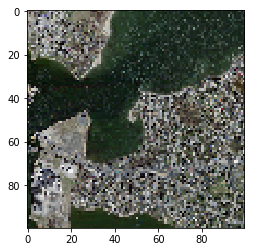

In [183]:
plt.imshow(data_small)

In [151]:
import rasterio
data = rasterio.open('/home/kolaleye/lustre/onitemi/data/mbd/training/24478885_15.tiff')

In [152]:
data.shape

(1500, 1500)

In [153]:
bands = np.dstack(data.read())

In [154]:
bands.shape

(1500, 1500, 3)

In [177]:
def sliding_window(nrow, ncol, patch_size,step=32):
    """Extract patches according to a sliding window.
    Args:            
        step (int, optional): The sliding window stride (defaults to 10px).
        patch_size(int, int, optional): The patch size (defaults to (20,20)).
        nrow, ncol: number of rows and columns in the tiff image
    Returns:
        list: list of patches with window_size dimensions
    """

    if step is None:
        step=patch_size/2

    #print('step, patch_size',step, patch_size)

    # slide a window across the image
    for x in range(0, nrow, step):
        if x + patch_size > nrow:
            x = nrow - patch_size
        for y in range(0, ncol, step):
            if y + patch_size > ncol:
                y = ncol - patch_size
            yield x, y
            

In [178]:
for i in sliding_window(1500, 1500, 64):
    print(i)

(0, 0)
(0, 32)
(0, 64)
(0, 96)
(0, 128)
(0, 160)
(0, 192)
(0, 224)
(0, 256)
(0, 288)
(0, 320)
(0, 352)
(0, 384)
(0, 416)
(0, 448)
(0, 480)
(0, 512)
(0, 544)
(0, 576)
(0, 608)
(0, 640)
(0, 672)
(0, 704)
(0, 736)
(0, 768)
(0, 800)
(0, 832)
(0, 864)
(0, 896)
(0, 928)
(0, 960)
(0, 992)
(0, 1024)
(0, 1056)
(0, 1088)
(0, 1120)
(0, 1152)
(0, 1184)
(0, 1216)
(0, 1248)
(0, 1280)
(0, 1312)
(0, 1344)
(0, 1376)
(0, 1408)
(0, 1436)
(0, 1436)
(32, 0)
(32, 32)
(32, 64)
(32, 96)
(32, 128)
(32, 160)
(32, 192)
(32, 224)
(32, 256)
(32, 288)
(32, 320)
(32, 352)
(32, 384)
(32, 416)
(32, 448)
(32, 480)
(32, 512)
(32, 544)
(32, 576)
(32, 608)
(32, 640)
(32, 672)
(32, 704)
(32, 736)
(32, 768)
(32, 800)
(32, 832)
(32, 864)
(32, 896)
(32, 928)
(32, 960)
(32, 992)
(32, 1024)
(32, 1056)
(32, 1088)
(32, 1120)
(32, 1152)
(32, 1184)
(32, 1216)
(32, 1248)
(32, 1280)
(32, 1312)
(32, 1344)
(32, 1376)
(32, 1408)
(32, 1436)
(32, 1436)
(64, 0)
(64, 32)
(64, 64)
(64, 96)
(64, 128)
(64, 160)
(64, 192)
(64, 224)
(64, 256)
(6